In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

api = wandb.Api()
ENT = "TomFrederik"
PROJ = "MT-ToyTask-Dreamer"
# JOB_ID = "9749161" #NOTE <-- change this for new runs
JOB_ID = "9757" #NOTE <-- change this for new runs
RED_VOLUME = True
NUM_SEEDS = 5

def gen_run_id_list(job_id):
    my_list = []
    for setting_num in range(21):
        for seed_num in range(3):
            my_list.append(f"setting_{setting_num}_seed_{seed_num}_job_{job_id}")
    return my_list

def fetch_last_loss(run_id: str, loss_name: str = "tuning_loss") -> float:
    run = api.run(f"{ENT}/{PROJ}/{run_id}")
    return run.history(keys=[f'Validation/{loss_name}']).iloc[-1][f'Validation/{loss_name}']


def fetch_loss_list_per_setting(job_id, loss_name: str = "tuning_loss"):
    out_dict = dict()
    for setting_num in tqdm(range(21)):
        loss_list = []
        if RED_VOLUME and setting_num not in [7, 8, 10, 12]:
            continue
        for seed_num in range(NUM_SEEDS):
            run_id = f"setting_{setting_num}_seed_{seed_num}_job_{job_id}"
            loss = fetch_last_loss(run_id, loss_name)
            loss_list.append(loss)
        out_dict[setting_num] = loss_list
    return out_dict

def compute_mean_std_per_setting(loss_dict):
    out_dict = dict()
    for key, val in loss_dict.items():
        mean = np.mean(val)
        std = np.std(val, ddof=1)
        out_dict[key] = (mean, std)
    return out_dict

In [2]:
# run id lists per setting
no_05 = [2, 4, 6]
yes_05 = [0, 1, 3, 5]
no_075 = [9, 11, 13]
yes_075 = [7, 8, 10, 12]
no_1 = [16, 18, 20]
yes_1 = [14, 15, 17, 19]

In [3]:
# loss_name = "value_prefix_loss"
loss_name = "tuning_loss"
mean_std_per_setting = compute_mean_std_per_setting(fetch_loss_list_per_setting(JOB_ID, loss_name))

100%|██████████| 21/21 [00:49<00:00,  2.37s/it]


In [4]:
print(mean_std_per_setting)

{0: (0.09741322994232178, 0.00826209529305394), 1: (0.2620909184217453, 0.05602805767832489), 2: (0.10324176847934723, 0.01067669460259164), 3: (0.5606084287166595, 0.3576048429803431), 4: (0.10817654728889466, 0.0046801342583392925), 5: (1.6268886089324952, 0.5360606813381568), 6: (0.15703381299972535, 0.011242732853146479), 7: (0.10562781244516373, 0.012797032976808497), 8: (0.4276047646999359, 0.21394261450090651), 9: (0.09539555311203003, 0.013106948179915864), 10: (0.8214975357055664, 0.477583857187739), 11: (0.10956733971834183, 0.015477105975902109), 12: (2.0525012016296387, 0.9206320121403853), 13: (0.14033413380384446, 0.012720113378047479), 14: (0.11478157341480255, 0.018101622349563445), 15: (0.371262913942337, 0.05772619298660581), 16: (0.1123006597161293, 0.006874000407247336), 17: (0.7725525617599487, 0.1824925994903882), 18: (0.12934673577547073, 0.01095434915337649), 19: (1.6492555618286133, 0.2819069224487864), 20: (0.14018458724021912, 0.0125321875630623)}


In [5]:
test_only_true_view_05 = [mean_std_per_setting[key] for key in yes_05]
test_only_true_view_075 = [mean_std_per_setting[key] for key in yes_075]
test_only_true_view_1 = [mean_std_per_setting[key] for key in yes_1]

test_only_false_view_05 = [mean_std_per_setting[key] for key in no_05]
test_only_false_view_075 = [mean_std_per_setting[key] for key in no_075]
test_only_false_view_1 = [mean_std_per_setting[key] for key in no_1]

In [6]:
print(test_only_true_view_05)

[(0.09741322994232178, 0.00826209529305394), (0.2620909184217453, 0.05602805767832489), (0.5606084287166595, 0.3576048429803431), (1.6268886089324952, 0.5360606813381568)]


## Bar plots

In [7]:
xticks_yes = np.array([0, 0.1, 0.2, 0.5])
xticks_no = np.array([0.1, 0.2, 0.5])
plot_kwargs = dict(width=0.025, capsize=4)

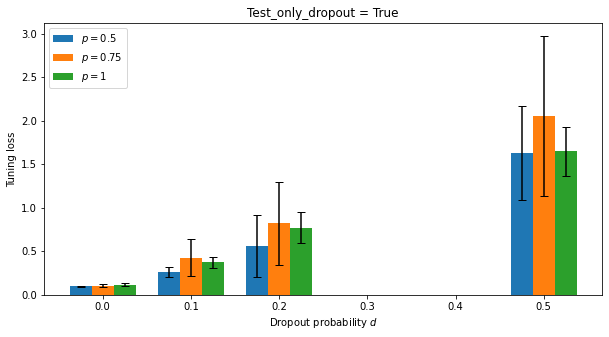

In [8]:
# eval for test_only true
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_yes-0.025, [x[0] for x in test_only_true_view_05], yerr=[x[1] for x in test_only_true_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_yes+0.025, [x[0] for x in test_only_true_view_1], yerr=[x[1] for x in test_only_true_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = True")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()

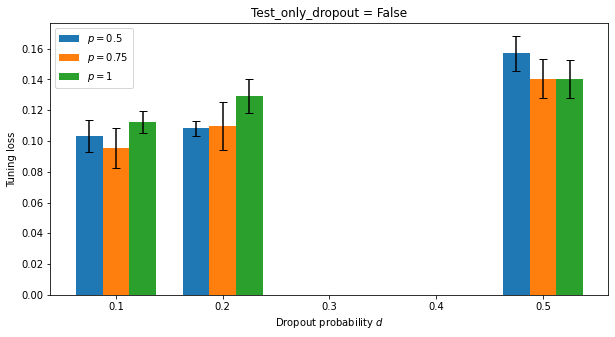

In [10]:
# eval for test_only false
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(xticks_no-0.025, [x[0] for x in test_only_false_view_05], yerr=[x[1] for x in test_only_false_view_05], label=r"$p=0.5$", **plot_kwargs)
ax.bar(xticks_no, [x[0] for x in test_only_false_view_075], yerr=[x[1] for x in test_only_false_view_075], label=r"$p=0.75$", **plot_kwargs)
ax.bar(xticks_no+0.025, [x[0] for x in test_only_false_view_1], yerr=[x[1] for x in test_only_false_view_1], label=r"$p=1$", **plot_kwargs)
plt.title("Test_only_dropout = False")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()

## Line plots

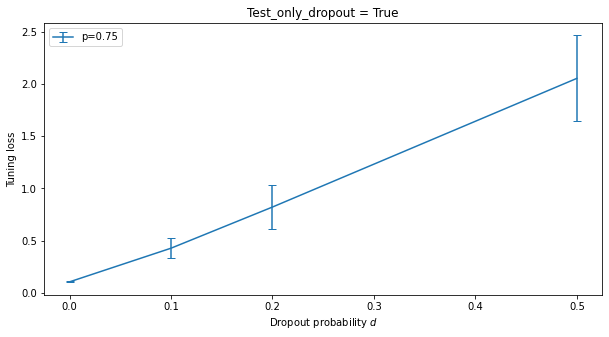

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(xticks_yes, [x[0] for x in test_only_true_view_075], label=r"$p=0.75$")
ax.errorbar(xticks_yes, [x[0] for x in test_only_true_view_075], yerr=[x[1] for x in test_only_true_view_075], label="p=0.75", capsize=plot_kwargs['capsize'])
plt.title("Test_only_dropout = True")
# plt.yscale("log")
plt.xlabel(r"Dropout probability $d$")
plt.ylabel("Tuning loss")
plt.legend()